In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import CrossEntropyLoss, Linear, Softmax, Sigmoid, Module
import torch.optim as optim
from scipy.optimize import minimize
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.connectors import TorchConnector
import qiskit
import qiskit_machine_learning
print(qiskit.version.get_version_info())
print(qiskit_machine_learning.version.get_version_info())

1.2.4
0.8.0


In [2]:
# Creating Circuit

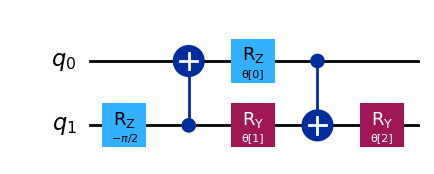

In [3]:
# Defining Pool Circuit
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

# Visual
params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

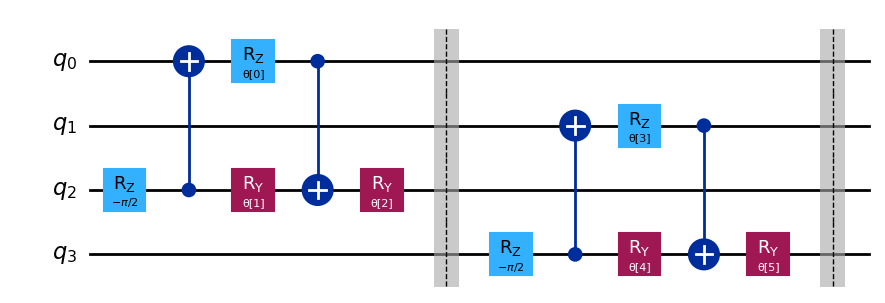

In [4]:
# Defining Pool Layer (Repeating Circuit on Neighboring Qubits)
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

# Visual
sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

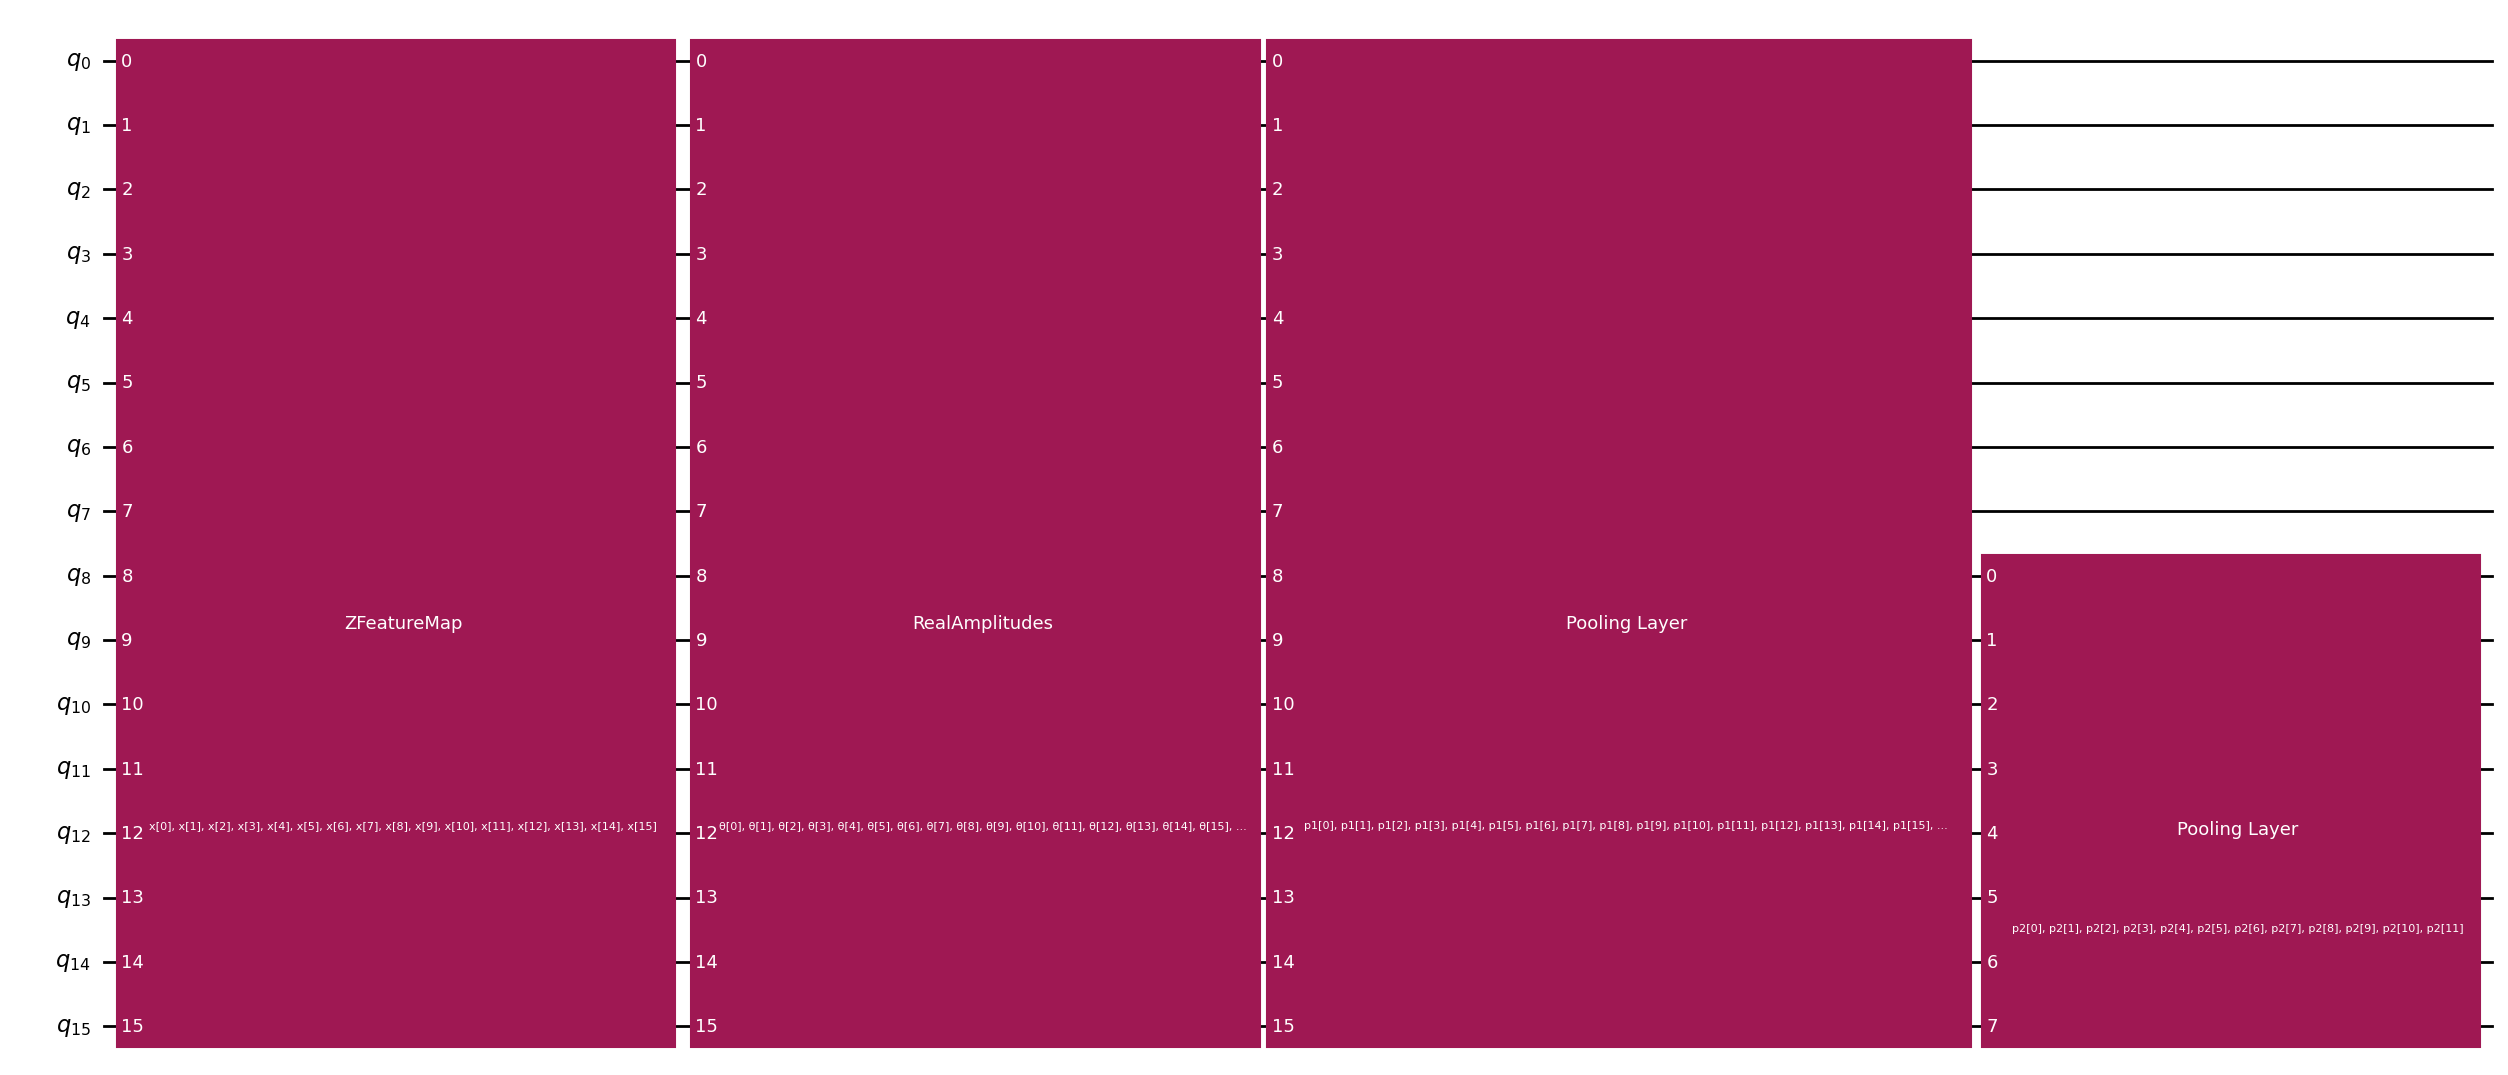

In [5]:
# Ansatz Instantiation Method
from qiskit import ClassicalRegister, QuantumRegister
def create_QCNN():
    feature_map = ZFeatureMap(16)
    ansatz = qiskit.circuit.library.RealAmplitudes(num_qubits=16, entanglement='full', reps=2, name='RealAmplitudes')
    # Combining the feature map and ansatz
    circuit = QNNCircuit(16)
    circuit.feature_map = feature_map
    circuit.ansatz = ansatz

    # First Pooling Layer
    ansatz.compose(pool_layer([0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15], "p1"), list(range(16)), inplace=True)

    # Second Pooling Layer
    ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8, 16)), inplace=True)

    return circuit

# Visual
display(create_QCNN().draw("mpl", fold = 50))

In [6]:
# Creating/Formatting Data

In [7]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/(255.0/np.pi), x_test[..., np.newaxis]/(255.0/np.pi)
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

2024-12-30 16:45:42.669658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735605942.682846  908380 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735605942.686783  908380 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-30 16:45:42.699727: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of original training examples: 60000
Number of original test examples: 10000


In [8]:
# Filter Values
a = 3
b = 4
c = 5
d = 6
def filter_abcd(x, y):
    keep = (y == a) | (y == b) | (y == c) | (y == d)
    x, y = x[keep], y[keep]
    return x,y

In [9]:
# Filtering using previous method.
x_train, y_train = filter_abcd(x_train, y_train)
x_test, y_test = filter_abcd(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 23312
Number of filtered test examples: 3842


6


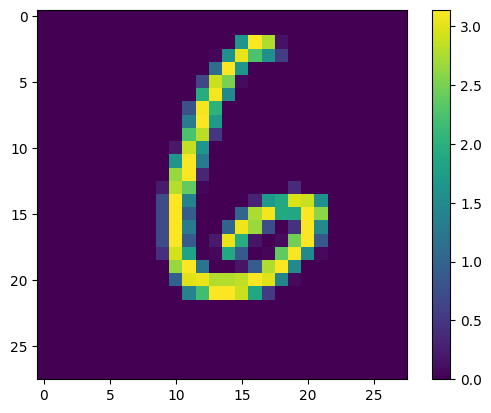

In [10]:
# Displaying Sample Image
img = 13
print(y_train[img])
plt.imshow(x_train[img, :, :, 0])
plt.colorbar()

In [11]:
# Resizing (Quantum Computing Simulation Limit)
x_train_small = tf.image.resize(x_train, (4,4), method = 'area').numpy()
x_test_small = tf.image.resize(x_test, (4,4), method = 'area').numpy()

I0000 00:00:1735605944.831428  908380 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


6


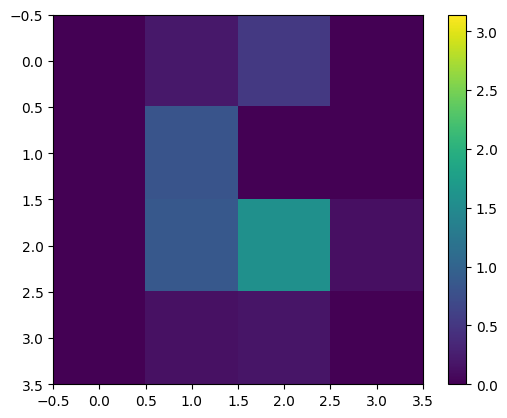

In [12]:
# Displaying Image Sample After Resizing
img = 13
print(y_train[img])
plt.imshow(x_train_small[img,:,:,0], vmin=0, vmax=np.pi)
plt.colorbar()

In [13]:
# Formatting Helper Methods
def format_data(a,b):
    x_reshaped = []
    x1_reshaped = []

    for g in a:
        x_reshaped.append(g.reshape(1,16))

    for g in b:
        x1_reshaped.append(g.reshape(1,16))

    final_x = []
    final_x1 = []

    for entry in x_reshaped:
        final_x.append(entry[0])

    for entry in x1_reshaped:
        final_x1.append(entry[0])
    return final_x, final_x1

def format_labels(y):
    y_temp = []
    for entry in y:
        if entry == a:
            y_temp.append(0)
        elif entry == b:
            y_temp.append(1)
        elif entry == c:
            y_temp.append(2)
        elif entry == d:
            y_temp.append(3)
    return y_temp

In [14]:
x,x1 = format_data(x_train_small, x_test_small)

# Easier to work with names
y = y_train
y1 = y_test

# Setting labels to 0,1,2,3 for easy reference later
y = format_labels(y)
y1 = format_labels(y1)

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)

# Limiting training dataset to lower training time.
x = x[0:256]
y = y[0:256]
x1 = x1[0:256]
y1 = y1[0:256]
print(x)
print(y)

[[0.         0.19058241 0.5850729  ... 1.2083628  0.15663964 0.        ]
 [0.0359542  0.         0.04701703 ... 0.         0.54685587 0.        ]
 [0.         0.26902792 0.86968946 ... 1.3765682  0.4684103  0.        ]
 ...
 [0.         0.3354049  0.         ... 0.40329048 0.46539322 0.        ]
 [0.         0.0548113  0.8850265  ... 0.9554263  0.27833077 0.        ]
 [0.         0.10283405 0.05279988 ... 0.35426205 0.24916515 0.        ]]
[2 1 0 1 0 2 0 3 3 1 1 0 0 3 2 3 3 0 2 0 0 1 1 1 1 3 1 2 3 3 0 3 0 1 3 1 3
 0 2 3 0 0 1 3 1 3 0 1 2 0 0 2 1 1 2 3 0 1 3 3 0 1 1 3 1 2 2 0 0 2 3 2 1 0
 0 3 0 0 1 3 2 3 1 0 0 2 1 3 2 3 0 2 0 0 0 3 1 2 3 2 1 1 2 3 1 2 0 0 2 3 2
 1 0 1 1 1 0 3 3 2 3 1 2 0 3 0 2 1 0 3 2 2 1 1 0 1 1 0 0 1 3 1 1 1 2 1 1 3
 0 3 2 3 1 2 0 2 1 1 1 2 2 3 0 3 3 0 2 1 1 3 0 0 1 2 3 2 0 2 1 0 3 0 3 0 2
 3 0 2 2 3 0 2 2 2 2 2 1 3 3 2 0 1 2 2 0 3 0 2 0 0 1 3 1 0 1 3 2 0 1 1 3 3
 3 1 1 3 2 0 2 1 2 2 3 2 0 3 2 0 0 1 3 2 2 1 3 0 3 1 1 3 0 3 0 1 2 1]


In [15]:
# Additional Helper Functions
def count(y):
    counta = 0
    countb = 0
    countc = 0
    countd = 0
    for i in range(len(y)):
        if y[i] == 0:
            counta+=1
        elif y[i] == 1:
            countb+=1
        elif y[i] == 2:
            countc+=1
        elif y[i] == 3:
            countd+=1
    return(counta, countb, countc, countd)

def balance_lists(x, y, max_count):
    """Balances two lists x and y based on the values in y (0 or 1)."""
    
    x_balanced = []
    y_balanced = []
    count0 = 0
    count1 = 0
    count2 = 0
    count3 = 0

    for i in range(len(y)):
        if y[i] == 0:
            if count0 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count0 += 1
        elif y[i] == 1:
            if count1 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count1 += 1
        elif y[i] == 2:
            if count2 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count2 += 1
        elif y[i] == 3:
            if count3 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count3 += 1
    return x_balanced, y_balanced

def shuffle(arr1, arr2):
    assert len(arr1) == len(arr2)
    p = np.random.permutation(len(arr1))
    return arr1[p], arr2[p]

In [16]:
# Further Data Cleaning Using Helper Functions
nums = count(y)
print("original:", nums)
max_count = min(nums)
print("max_count =", max_count)
x,y = balance_lists(x, y, max_count)

print("balanced:", count(y))

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)
objective_func_vals = []

x,y = shuffle(x,y)
print("shuffled:", count(y))

print("final:", x)
print(y)

original: (66, 68, 60, 62)
max_count = 60
balanced: (60, 60, 60, 60)
shuffled: (60, 60, 60, 60)
final: [[0.         0.         0.05003417 ... 0.23785086 0.05380558 0.        ]
 [0.         0.47117603 0.         ... 0.12143972 0.55666155 0.        ]
 [0.         0.69419265 0.         ... 0.10635403 0.1941024  0.        ]
 ...
 [0.         0.7655982  0.6687984  ... 0.9780548  0.7009812  0.        ]
 [0.         0.6481813  0.9511521  ... 1.2697114  0.45785034 0.        ]
 [0.         0.8872893  0.3678391  ... 1.1781915  0.62580425 0.        ]]
[2 3 3 0 3 0 3 3 1 1 1 2 0 1 1 2 2 3 0 0 3 3 1 0 1 2 0 0 2 2 3 3 0 2 2 2 1
 1 3 3 0 2 1 1 0 0 2 0 3 2 3 0 2 0 1 0 1 1 0 1 1 3 2 0 3 2 3 0 3 1 3 2 3 0
 1 0 3 3 0 3 2 1 3 0 0 3 1 3 1 0 0 1 3 2 3 3 1 1 3 0 2 2 2 3 0 2 3 2 0 0 1
 2 1 3 1 2 3 0 0 2 1 0 3 2 3 1 2 0 0 3 1 1 2 3 2 2 2 1 2 1 0 0 1 0 0 3 1 1
 1 0 1 3 2 2 0 1 1 2 0 1 3 1 3 2 1 3 2 1 2 1 2 2 2 1 1 2 0 3 2 2 3 0 1 2 0
 2 1 1 3 1 3 2 0 3 0 3 2 1 2 3 1 0 3 2 2 0 3 3 1 3 2 3 0 1 1 2 2 0 3 0 0 1
 2 

In [17]:
# Tensor for Pytorch
X = torch.tensor(x, dtype=torch.float32).to("cuda")
Y = torch.tensor(y, dtype=torch.long).to("cuda")
X1 = torch.tensor(x1, dtype=torch.float32).to("cuda")
Y1 = torch.tensor(y1, dtype=torch.long).to("cuda")

In [18]:
# One-Hot Encoding for Final Processing
num_classes = 4
Y = (torch.nn.functional.one_hot(Y, num_classes=num_classes).float())
Y1 = (torch.nn.functional.one_hot(Y1, num_classes=num_classes).float())

In [19]:
print(X,Y,X1,Y1)

tensor([[0.0000, 0.0000, 0.0500,  ..., 0.2379, 0.0538, 0.0000],
        [0.0000, 0.4712, 0.0000,  ..., 0.1214, 0.5567, 0.0000],
        [0.0000, 0.6942, 0.0000,  ..., 0.1064, 0.1941, 0.0000],
        ...,
        [0.0000, 0.7656, 0.6688,  ..., 0.9781, 0.7010, 0.0000],
        [0.0000, 0.6482, 0.9512,  ..., 1.2697, 0.4579, 0.0000],
        [0.0000, 0.8873, 0.3678,  ..., 1.1782, 0.6258, 0.0000]],
       device='cuda:0') tensor([[0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
      

In [20]:
# Training

In [21]:
# Pytorch Circuit Module
import torch.nn as nn
class Model(Module): # Simplified
    def __init__(self, qnn_module):
        super().__init__()
        self.qnn_module = qnn_module

    def forward(self, x):
        x = self.qnn_module(x)
        return x

In [22]:
from qiskit_aer.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_algorithms.gradients import ReverseEstimatorGradient
from qiskit_machine_learning.utils import algorithm_globals

# Reproducable seeds
num_qubits = 16
algorithm_globals.random_seed = 65
seed = 90

# Creating GPU compatible Estimator primitive
sampler = Estimator()
sampler.set_options(device='GPU')
sampler.set_options(method="statevector")
sampler.set_options(seed = seed)

observable_z12 = SparsePauliOp.from_sparse_list([("Z", [12], 1)], num_qubits=num_qubits)
observable_z13 = SparsePauliOp.from_sparse_list([("Z", [13], 1)], num_qubits=num_qubits)
observable_z14 = SparsePauliOp.from_sparse_list([("Z", [14], 1)], num_qubits=num_qubits)
observable_z15 = SparsePauliOp.from_sparse_list([("Z", [15], 1)], num_qubits=num_qubits)
observables = [observable_z12, observable_z13, observable_z14, observable_z15]

# Instantiating underlying EstimatorQNN
estimator = EstimatorQNN(
    estimator = sampler,
    circuit = create_QCNN(),
    gradient = ReverseEstimatorGradient(sampler),
    observables=observables,
    input_gradients = True,
)

# Initial Forward Weights
weights = algorithm_globals.random.random(estimator.num_weights)

# Checking Data Forward Result
estimator.forward(input_data = x1[:30], weights = weights)

/tmp/ipykernel_908380/2072519906.py:24: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator = EstimatorQNN(
/tmp/ipykernel_908380/2072519906.py:24: UserWarning: No number of qubits was not specified (None) and was retrieved from `circuit` (16). If `circuit` is transpiled, this may cause unstable behaviour.
  estimator = EstimatorQNN(


array([[ 0.265625  , -0.109375  , -0.02734375, -0.09570312],
       [ 0.265625  ,  0.015625  , -0.01171875, -0.03320312],
       [ 0.15429688, -0.06835938,  0.08007812, -0.03710938],
       [ 0.26953125, -0.09960938,  0.03320312, -0.1015625 ],
       [ 0.17773438, -0.02734375,  0.015625  , -0.10546875],
       [ 0.23046875,  0.08984375,  0.046875  , -0.13671875],
       [ 0.21875   , -0.12695312,  0.05078125, -0.09960938],
       [ 0.23828125, -0.0703125 ,  0.02734375, -0.08984375],
       [ 0.2578125 , -0.10546875,  0.05078125, -0.09375   ],
       [ 0.23632812, -0.1015625 ,  0.02929688, -0.12304688],
       [ 0.31445312, -0.14648438,  0.05664062, -0.09765625],
       [ 0.29882812, -0.0625    ,  0.00585938, -0.00195312],
       [ 0.3125    , -0.05664062,  0.05273438, -0.0859375 ],
       [ 0.22265625, -0.06640625,  0.        , -0.03515625],
       [ 0.29492188, -0.06835938, -0.11328125, -0.14257812],
       [ 0.27929688, -0.04882812,  0.0234375 , -0.08203125],
       [ 0.26171875, -0.

In [23]:
# Wrapping estimator with initial weights under TorchConnecter, itself under Pytorch Module.
model = Model(TorchConnector(estimator, weights))
model.to("cuda")
next(model.parameters()).is_cuda

True

In [24]:
model(X[:20])

tensor([[ 0.2480, -0.0859, -0.0547, -0.0957],
        [ 0.2852, -0.0684,  0.0195, -0.1191],
        [ 0.2227, -0.0332,  0.0898, -0.0723],
        [ 0.0781, -0.0430,  0.0098, -0.0469],
        [ 0.2109, -0.0273,  0.0137, -0.0977],
        [ 0.1934, -0.0605, -0.0840, -0.0488],
        [ 0.1719, -0.0703,  0.0527, -0.0996],
        [ 0.2637, -0.0840,  0.0234, -0.0859],
        [ 0.2695, -0.1211,  0.0410, -0.0605],
        [ 0.2480, -0.1270,  0.0273, -0.1211],
        [ 0.2773, -0.1133,  0.0625, -0.1523],
        [ 0.2051,  0.0156,  0.0059, -0.0020],
        [ 0.3008, -0.1270,  0.0547, -0.0859],
        [ 0.2480, -0.0742, -0.0039, -0.0312],
        [ 0.2266, -0.0605,  0.0215, -0.0801],
        [ 0.2715, -0.0918,  0.0215, -0.0820],
        [ 0.2773, -0.1445,  0.0176, -0.0195],
        [ 0.1191, -0.0137,  0.0098, -0.0508],
        [ 0.1836, -0.0977, -0.0137, -0.0820],
        [ 0.1348, -0.1289,  0.0625, -0.0566]], device='cuda:0',
       grad_fn=<_TorchNNFunctionBackward>)

In [25]:
def accuracy(output, y):
    preds = torch.argmax(output, dim=1)
    true = torch.argmax(y, dim=1)
    correct = (preds == true).sum().item()
    return (correct / y.size(0)) * 100

In [26]:
def train(model, X, Y, loss_function, optimizer, epochs, loss_list = [], acc_list = [], test_acc_list=[], i = 0):
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    if i == 0:
        output = model(X)
        output0 = model(X1)
        epoch_loss = loss_function(output, Y).item()
        epoch_acc = accuracy(output, Y)
        epoch_test_acc = accuracy(output0, Y1)
        loss_list.append(epoch_loss)
        acc_list.append(epoch_acc)
        test_acc_list.append(epoch_test_acc)
        print(f"Epoch: {i}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Test Accuracy: {epoch_test_acc:.2f}%")
    else:
        for e in range(i+1): # Considering 0th epoch in list as well
            print(f"Epoch: {e}, Loss: {loss_list[e]:.4f}, Accuracy: {acc_list[e]:.2f}%, Test Accuracy: {test_acc_list[e]:.2f}%")   
        
    for epoch in range(epochs):
        # Forward pass
        output = model(X)
        loss = loss_function(output, Y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate loss and accuracy for the entire epoch (optional, for monitoring)
        with torch.no_grad():
            output = model(X)
            output0 = model(X1)
            epoch_loss = loss_function(output, Y).item()
            epoch_acc = accuracy(output, Y)
            epoch_test_acc = accuracy(output0, Y1)
            loss_list.append(epoch_loss)
            acc_list.append(epoch_acc)
            test_acc_list.append(epoch_test_acc)
            print(f"Epoch: {epoch+1+i}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Test Accuracy: {epoch_test_acc:.2f}%")
    return loss_list, acc_list, test_acc_list

In [27]:
optimizer = optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_function = CrossEntropyLoss()

In [36]:
# Train the Model
loss_list, acc_list, test_acc_list = train(model = model, X = X, Y = Y, optimizer = optimizer, loss_function = loss_function, epochs = 30, i = 10, loss_list=loss_list, acc_list=acc_list, test_acc_list=test_acc_list)

Epoch: 0, Loss: 1.4073, Accuracy: 25.00%, Test Accuracy: 25.39%
Epoch: 1, Loss: 1.3794, Accuracy: 33.75%, Test Accuracy: 33.20%
Epoch: 2, Loss: 1.3648, Accuracy: 38.75%, Test Accuracy: 39.45%
Epoch: 3, Loss: 1.3488, Accuracy: 45.83%, Test Accuracy: 38.28%
Epoch: 4, Loss: 1.3300, Accuracy: 47.08%, Test Accuracy: 39.45%
Epoch: 5, Loss: 1.3143, Accuracy: 49.58%, Test Accuracy: 35.55%
Epoch: 6, Loss: 1.3010, Accuracy: 50.00%, Test Accuracy: 35.94%
Epoch: 7, Loss: 1.2935, Accuracy: 51.25%, Test Accuracy: 35.94%
Epoch: 8, Loss: 1.2874, Accuracy: 48.75%, Test Accuracy: 35.94%
Epoch: 9, Loss: 1.2794, Accuracy: 46.25%, Test Accuracy: 37.50%
Epoch: 10, Loss: 1.2725, Accuracy: 47.92%, Test Accuracy: 35.55%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 11, Loss: 1.2682, Accuracy: 50.42%, Test Accuracy: 40.23%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 12, Loss: 1.2497, Accuracy: 52.50%, Test Accuracy: 37.89%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 13, Loss: 1.2462, Accuracy: 43.75%, Test Accuracy: 31.64%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 14, Loss: 1.2432, Accuracy: 46.25%, Test Accuracy: 38.28%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 15, Loss: 1.2377, Accuracy: 47.08%, Test Accuracy: 35.16%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 16, Loss: 1.2353, Accuracy: 47.08%, Test Accuracy: 34.77%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 17, Loss: 1.2366, Accuracy: 47.08%, Test Accuracy: 34.77%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 18, Loss: 1.2381, Accuracy: 45.83%, Test Accuracy: 33.20%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 19, Loss: 1.2381, Accuracy: 47.08%, Test Accuracy: 33.59%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 20, Loss: 1.2373, Accuracy: 48.33%, Test Accuracy: 34.38%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 21, Loss: 1.2369, Accuracy: 47.50%, Test Accuracy: 33.98%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 22, Loss: 1.2350, Accuracy: 47.50%, Test Accuracy: 35.94%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 23, Loss: 1.2342, Accuracy: 48.33%, Test Accuracy: 34.77%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 24, Loss: 1.2339, Accuracy: 48.75%, Test Accuracy: 35.55%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 25, Loss: 1.2329, Accuracy: 48.75%, Test Accuracy: 35.55%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 26, Loss: 1.2315, Accuracy: 51.67%, Test Accuracy: 35.55%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 27, Loss: 1.2311, Accuracy: 49.17%, Test Accuracy: 35.94%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 28, Loss: 1.2306, Accuracy: 49.17%, Test Accuracy: 33.98%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 29, Loss: 1.2305, Accuracy: 48.33%, Test Accuracy: 35.94%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 30, Loss: 1.2301, Accuracy: 47.08%, Test Accuracy: 34.38%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 31, Loss: 1.2286, Accuracy: 48.75%, Test Accuracy: 35.16%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 32, Loss: 1.2290, Accuracy: 47.50%, Test Accuracy: 35.55%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 33, Loss: 1.2286, Accuracy: 49.17%, Test Accuracy: 35.94%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 34, Loss: 1.2276, Accuracy: 49.58%, Test Accuracy: 36.33%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 35, Loss: 1.2269, Accuracy: 49.58%, Test Accuracy: 35.94%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 36, Loss: 1.2267, Accuracy: 49.17%, Test Accuracy: 34.77%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 37, Loss: 1.2258, Accuracy: 49.17%, Test Accuracy: 35.55%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 38, Loss: 1.2256, Accuracy: 50.83%, Test Accuracy: 35.94%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 39, Loss: 1.2248, Accuracy: 50.83%, Test Accuracy: 37.11%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 40, Loss: 1.2241, Accuracy: 51.67%, Test Accuracy: 35.94%


In [37]:
print(loss_list, acc_list, test_acc_list)

[1.4073412418365479, 1.3793892860412598, 1.3647801876068115, 1.348819375038147, 1.3300392627716064, 1.3143373727798462, 1.3010289669036865, 1.2935181856155396, 1.2873765230178833, 1.2793917655944824, 1.272493839263916, 1.268210530281067, 1.2497243881225586, 1.246192455291748, 1.24324631690979, 1.2377188205718994, 1.2353216409683228, 1.236552119255066, 1.2381017208099365, 1.2381300926208496, 1.2372575998306274, 1.2368571758270264, 1.2349772453308105, 1.2342215776443481, 1.2339454889297485, 1.2328914403915405, 1.2314916849136353, 1.231063723564148, 1.2306206226348877, 1.2304561138153076, 1.2301208972930908, 1.2285761833190918, 1.2289739847183228, 1.2285981178283691, 1.227631688117981, 1.2269171476364136, 1.2266793251037598, 1.2258468866348267, 1.2256444692611694, 1.2247902154922485, 1.224098801612854] [25.0, 33.75, 38.75, 45.83333333333333, 47.083333333333336, 49.583333333333336, 50.0, 51.24999999999999, 48.75, 46.25, 47.91666666666667, 50.416666666666664, 52.5, 43.75, 46.25, 47.08333333

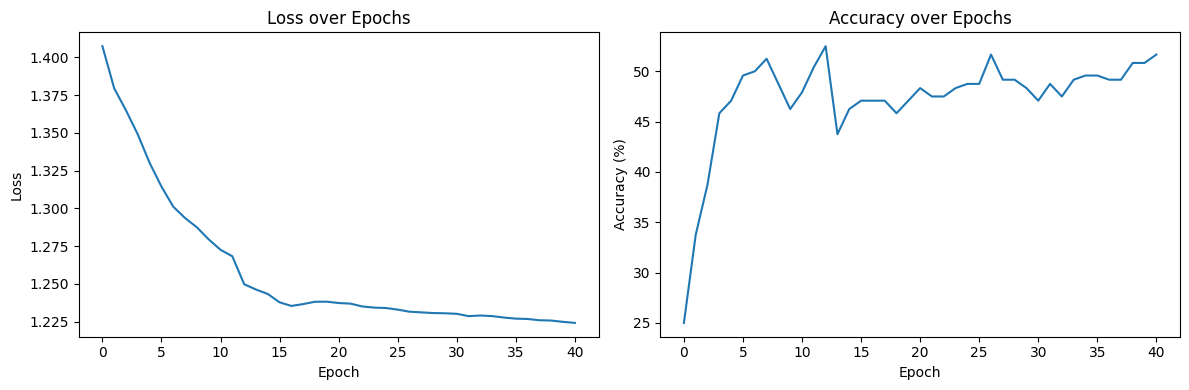

In [38]:
# Plot Loss and Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_list)
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(acc_list)
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.tight_layout()
plt.show()

In [39]:
savemodel = {'model': model, 'optimizer': optimizer.state_dict()}
print(next(model.parameters()).is_cuda)
torch.save(savemodel, "BasicCircuit")
print(next(model.parameters()).is_cuda)

True
True


In [40]:
evalmodel = torch.load("BasicCircuit", weights_only=False)['model'].to("cuda")
evalmodel.eval()
output0 = evalmodel(X)
output1 = evalmodel(X1)
print(f"Train Accuracy: {accuracy(output0, Y)}%")
print(f"Test Accuracy: {accuracy(output1, Y1)}%")

Train Accuracy: 51.66666666666667%
Test Accuracy: 35.9375%


In [41]:
def translate(array):
    arr = []
    for e in array:
        arr.append(torch.argmax(e))
    return arr
print(f"output 0: {translate(output0)}, \n Y:       {translate(Y)}, \n output 1: {translate(output1)}, \n Y1:       {translate(Y1)}")

output 0: [tensor(2, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3, device='cuda:0'), tensor(0, device='cuda:0'), tensor(3, device='cuda:0'), tensor(2, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(3, device='cuda:0'), tensor(0, device='cuda:0'), tensor(3, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(3, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3, device='cuda:0'), tensor(0, device='cuda:0'), tensor(3, device='cuda:0'), tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(2, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3, device='cuda:0'), tensor(0, device='cuda:0'), tensor(3, device='cuda:0'), tensor(1, device='cuda:0'), tensor(2,

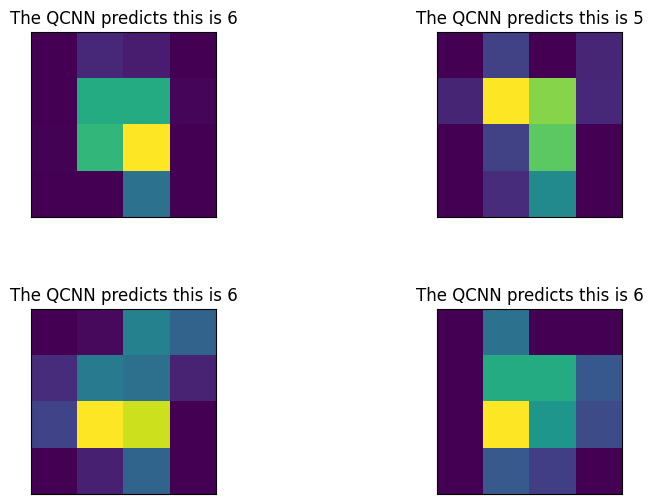

In [42]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(X1.detach().cpu().numpy()[i].reshape(4, 4), aspect="equal")
    if torch.argmax(output1[i]) == 0:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 3")
    if torch.argmax(output1[i]) == 1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 4")
    if torch.argmax(output1[i]) == 2:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 5")
    if torch.argmax(output1[i]) == 3:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 6")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

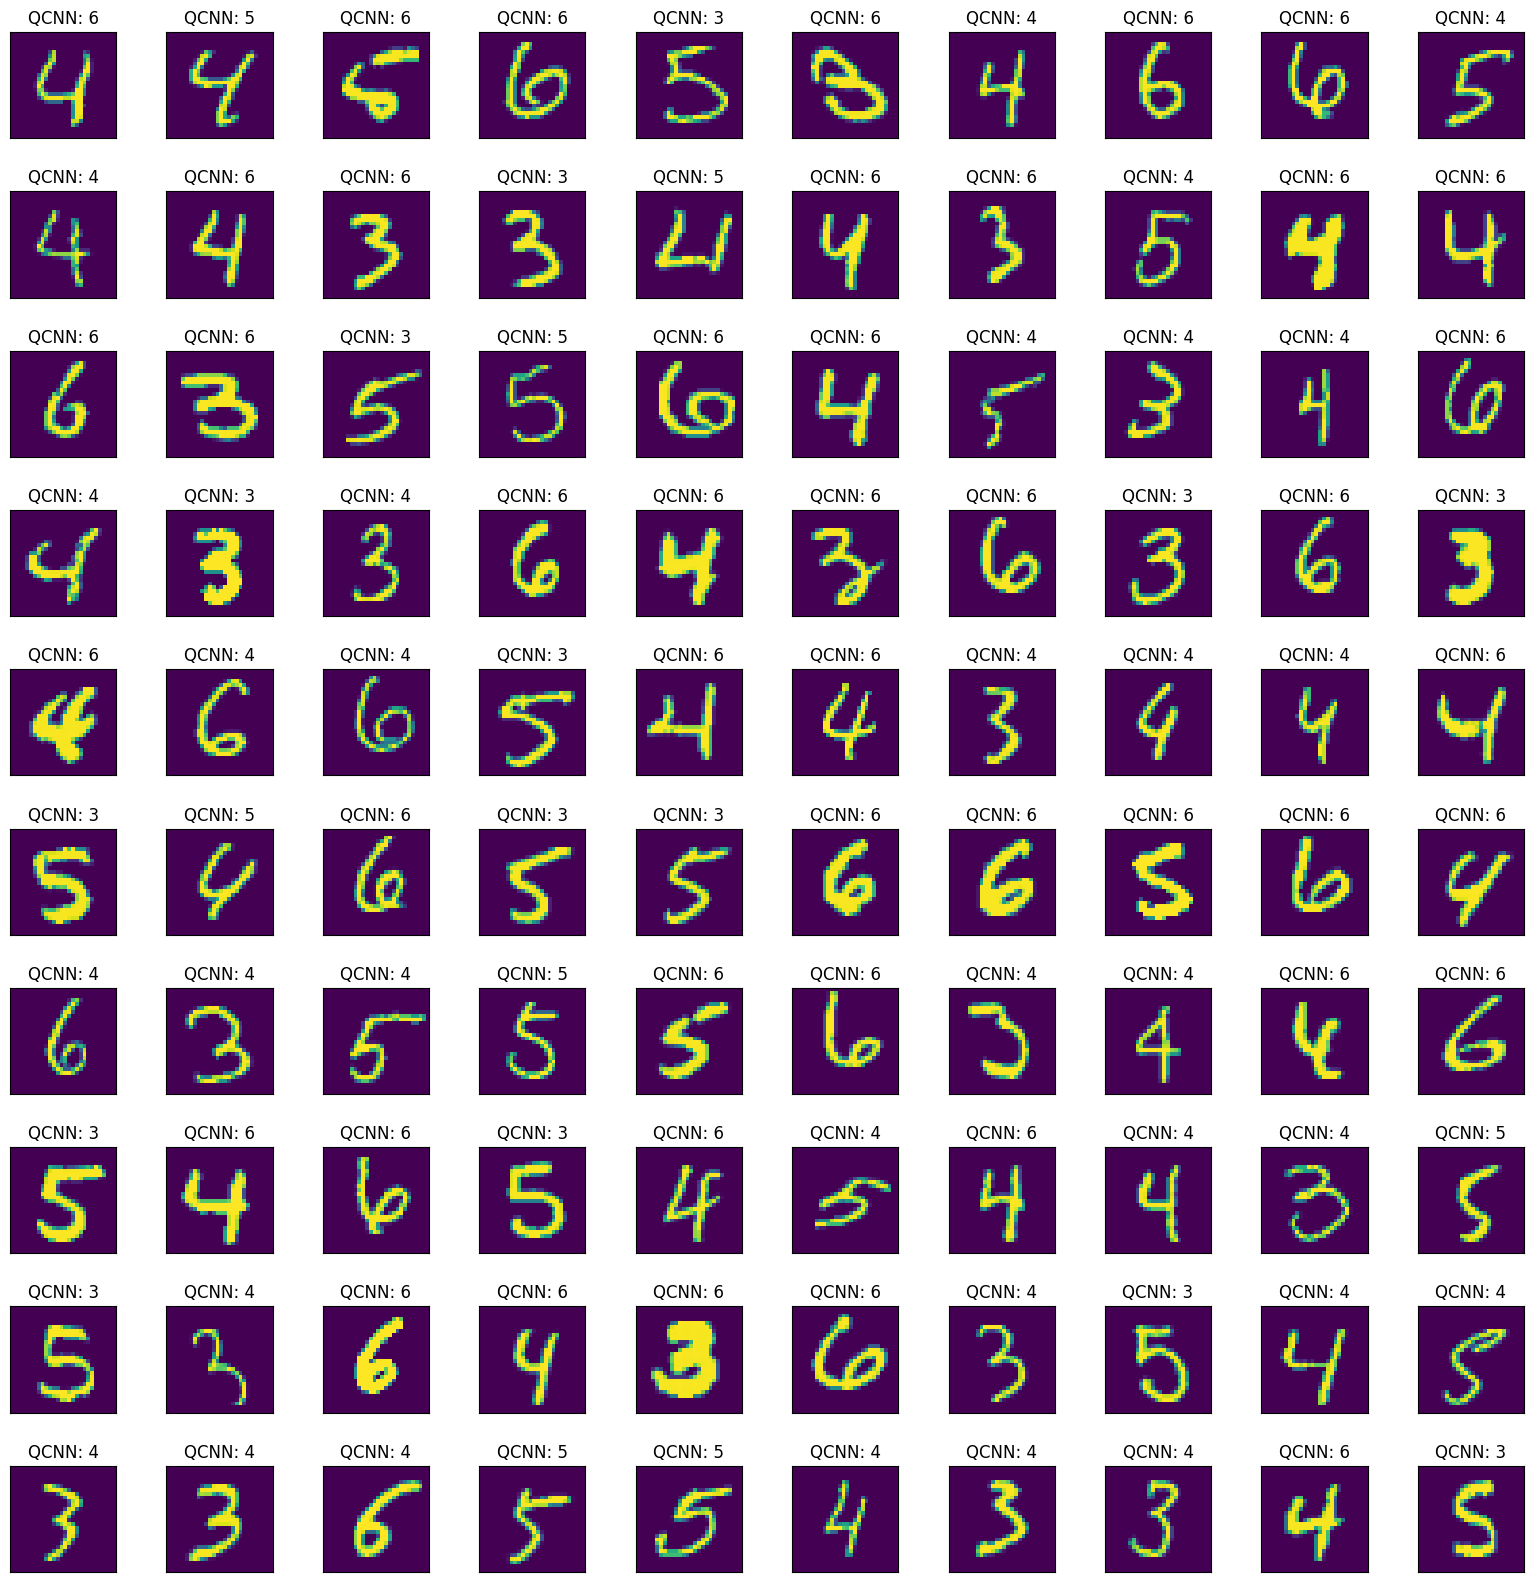

In [43]:
num_rows = 10
num_cols = 10
fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 20),
                       subplot_kw={"xticks": [], "yticks": []})

for i in range(num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    
    if i < len(x_test) and i < len(output1):
      ax[row, col].imshow(x_test[i].reshape(28, 28), aspect="equal")

      if torch.argmax(output1[i]) == 0:
          ax[row, col].set_title("QCNN: 3")
      elif torch.argmax(output1[i]) == 1:
          ax[row, col].set_title("QCNN: 4")
      elif torch.argmax(output1[i]) == 2:
          ax[row, col].set_title("QCNN: 5")
      elif torch.argmax(output1[i]) == 3:
          ax[row, col].set_title("QCNN: 6")
    else:
        ax[row, col].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show()